# True Solution and Quick Verification

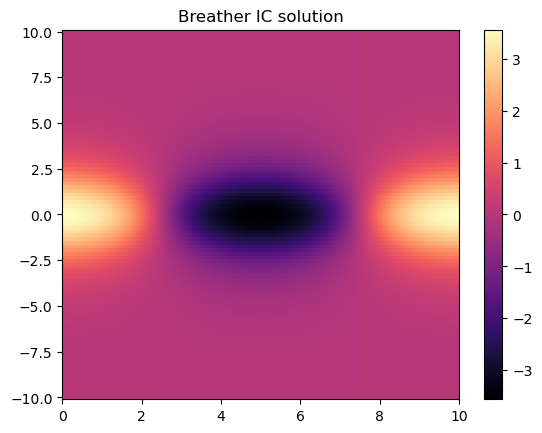

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pickle
import os

from constrained_nn_eq_discovery import numerics, utils, dhpm, training

import importlib
importlib.reload(utils)
importlib.reload(training)

# set cmap for this notebook
plt.rcParams['image.cmap'] = 'magma'

ic = 'breather'
# ic = 'custom'

n_x = 100
n_t = 2000
x = torch.linspace(-10, 10, n_x)
t = torch.linspace(0, 10, n_t)
X, T = torch.meshgrid(x, t, indexing='ij')
plt.figure()
if ic == 'breather':
    U_true = utils.breather(X, T)
    ic_fn = utils.breather_ic
    uv0 = ic_fn(x)
    plt.title("Breather IC solution")
elif ic == 'custom':
    # show ic
    ic_fn = utils.custom_ic
    uv0 = utils.custom_ic(x)
    # solve with FD to get data
    U_true = numerics.solve_pde_2nd_in_time(uv0, x, t, utils.sine_gordon).T
    plt.title("Custom IC solution")
plt.pcolor(T, X, U_true)
cbar = plt.colorbar(plt.pcolor(T, X, U_true))

# Begin Actual Study

Data shape: torch.Size([20, 25])
Device: cuda
l2 nn: 0.99731, l2 pde: 4.60136


Text(0.5, 1.0, 'Before training')

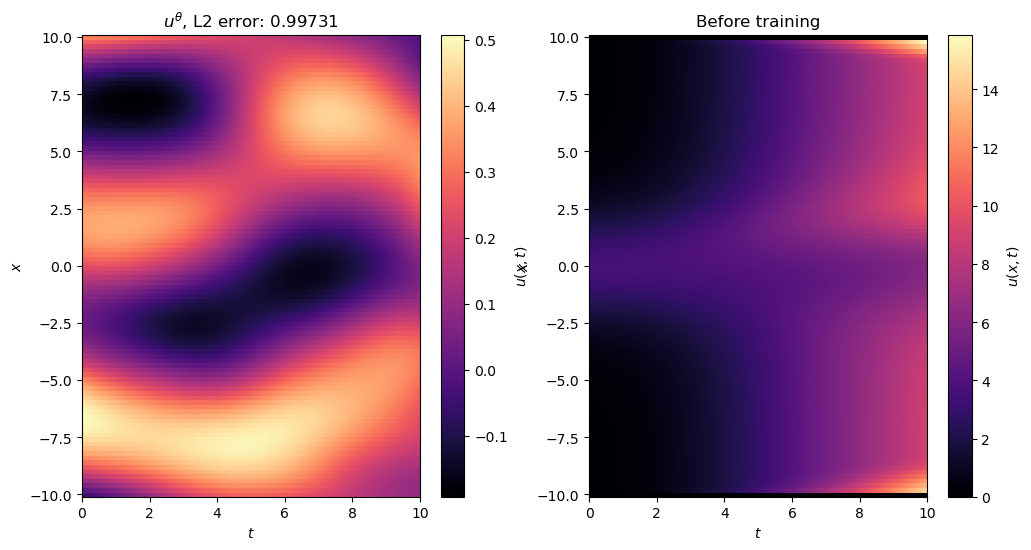

In [5]:
class debugN(nn.Module):
    def __init__(self, p1=-1.0, p2=1.0):
        super().__init__()
        self.p1 = nn.Parameter(torch.tensor(p1))
        self.p2 = nn.Parameter(torch.tensor(p2))

    def forward(self, big_u):
        u = big_u[:, 0:1]
        uxx = big_u[:, 2:3]
        return self.p1 * torch.sin(u) + self.p2 * uxx


torch.manual_seed(0)
noise_level = 0.5
ss_x = 5
ss_t = 80
identifier_str = f'ssx{ss_x}_sst{ss_t}_nl{noise_level}_nx{n_x}_nt{n_t}_{ic}'
U_data, X_data, T_data = utils.get_data(U_true, X, T, noise_level, ss_x, ss_t)
utils.save_data(U_data, X_data, T_data, '../data/'+identifier_str)
save_folder = f'../models/' + identifier_str
print(f'Data shape: {U_data.shape}')
os.makedirs(save_folder, exist_ok=True)

u_layers = [2, 32, 32, 1]
N_layers = [3, 16, 16, 1]
act = 'sin'
u_dnn = dhpm.DNN(u_layers, act)
N_dnn = dhpm.DNN(N_layers, 'sin')
# N_dnn = debugN(0.0, 0.0)
model = dhpm.EqDiscoveryModel(u_dnn, N_dnn)

def get_pde_error(N):
    with torch.no_grad():
        U_pde = numerics.solve_pde_2nd_in_time(uv0, x, t, N).T
    l2_error_pde = utils.l2_error(U_true, U_pde)
    return l2_error_pde, U_pde

def plot_model():
    with torch.no_grad():
        U_nn = model.u_on_meshgrid(T, X)
    l2_error = utils.l2_error(U_true, U_nn)
    l2_error_pde, U_pde = get_pde_error(model.N_dnn)
    print(f'l2 nn: {l2_error:.5f}, l2 pde: {l2_error_pde:.5f}')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].pcolor(T, X, U_nn)
    cbar = plt.colorbar(ax[0].pcolor(T, X, U_nn))
    cbar.set_label("$u(x,t)$")
    ax[1].pcolor(T, X, U_pde)
    cbar = plt.colorbar(ax[1].pcolor(T, X, U_pde))
    cbar.set_label("$u(x,t)$")
    ax[0].set_title(rf"$u^\theta$, L2 error: {l2_error:.5f}")
    ax[1].set_title(rf"$N^\phi$ PDE solution, L2 error: {l2_error_pde:.5f}")
    # x and y labels, colobar label
    for a in ax:
        a.set_xlabel("$t$")
        a.set_ylabel("$x$")
    return fig, ax

# convert from 2D to 1D (b, 1), and (b, 2) for xt
u_train = U_data.reshape(-1, 1)
xt_train = torch.cat([X_data.reshape(-1, 1), T_data.reshape(-1, 1)], dim=1)
xt_f = torch.cat([X_data.reshape(-1, 1), T_data.reshape(-1, 1)], dim=1).requires_grad_(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'Device: {device}')

plot_model()
plt.title('Before training')

Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i0_lam100.0_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.000003113248, Loss u: 1.308919787407
Epoch 800/100000, Loss N: 0.000002451505, Loss u: 1.209023714066
Epoch 1200/100000, Loss N: 0.000003799636, Loss u: 0.951563060284
Epoch 1600/100000, Loss N: 0.000005546670, Loss u: 0.621621608734
Epoch 2000/100000, Loss N: 0.000003307556, Loss u: 0.430851519108
Epoch 2400/100000, Loss N: 0.000003352409, Loss u: 0.368537425995
Epoch 2800/100000, Loss N: 0.000003799334, Loss u: 0.343825936317
Epoch 3200/100000, Loss N: 0.000003859030, Loss u: 0.329692333937
Epoch 3600/100000, Loss N: 0.000004015213, Loss u: 0.318417698145
Epoch 4000/100000, Loss N: 0.000003789480, Loss u: 0.309519827366
Epoch 4400/100000, Loss N: 0.000003922236, Loss u: 0.301789492369
Epoch 4800/100000, Loss N: 0.000002636824, Loss u: 0.296270877123
Epoch 5200/100000, Loss N: 0.00000233

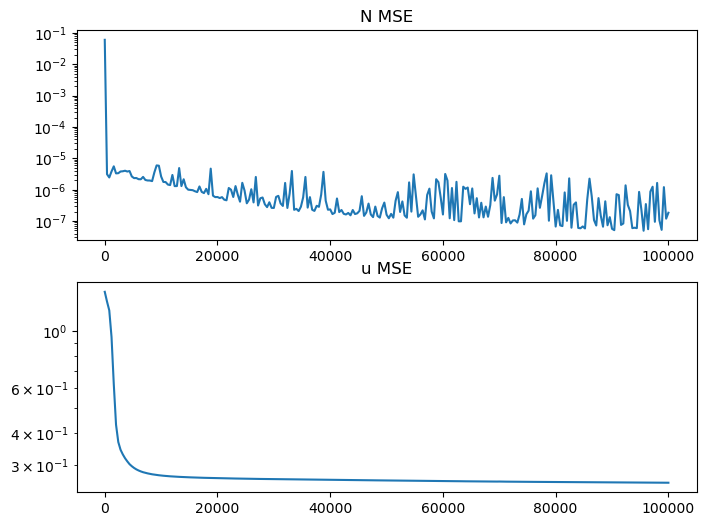

l2 nn: 0.14455, l2 pde: 0.15395
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i1_lam10.0_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.000227885379, Loss u: 0.285416156054
Epoch 800/100000, Loss N: 0.000082487793, Loss u: 0.263616263866
Epoch 1200/100000, Loss N: 0.000062500330, Loss u: 0.260902225971
Epoch 1600/100000, Loss N: 0.000060258535, Loss u: 0.259424895048
Epoch 2000/100000, Loss N: 0.000064054177, Loss u: 0.258276790380
Epoch 2400/100000, Loss N: 0.000065765023, Loss u: 0.257003933191
Epoch 2800/100000, Loss N: 0.000074354139, Loss u: 0.254846155643
Epoch 3200/100000, Loss N: 0.000070764618, Loss u: 0.252782016993
Epoch 3600/100000, Loss N: 0.000061547595, Loss u: 0.250503301620
Epoch 4000/100000, Loss N: 0.000065727894, Loss u: 0.248001009226
Epoch 4400/100000, Loss N: 0.000065176297, Loss u: 0.245249524713
Epoch 4800/100000, Loss N: 0.000062727500, Loss u: 0.242186799645
Epoch 

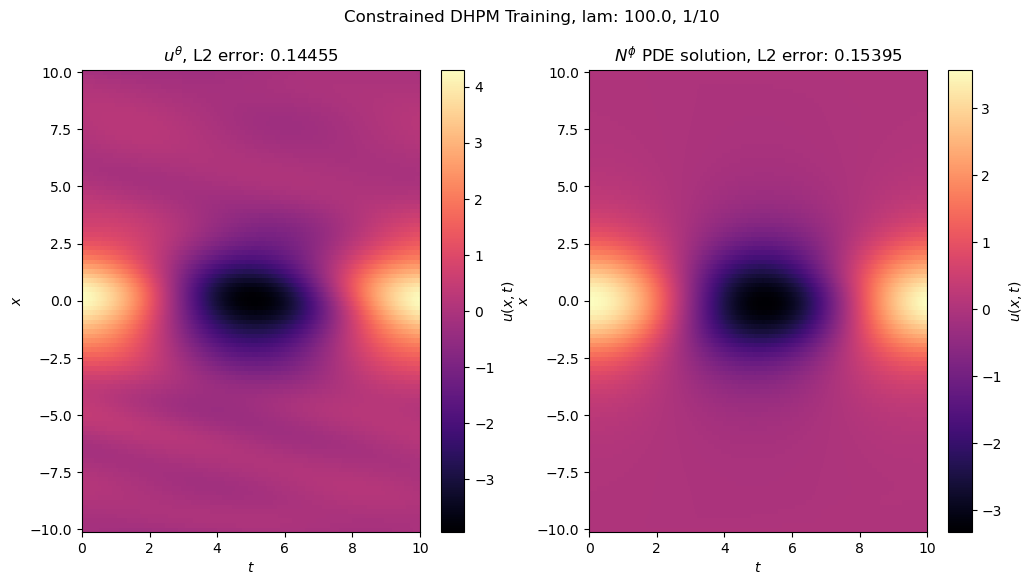

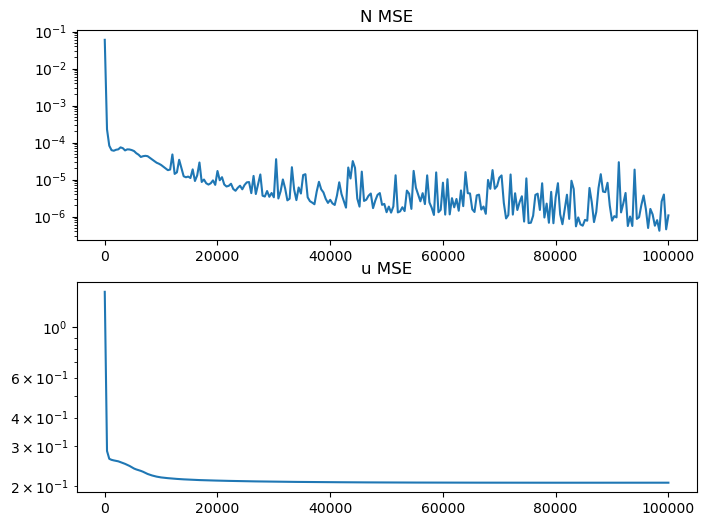

l2 nn: 0.27492, l2 pde: 0.72506
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i2_lam1.0_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.005214561708, Loss u: 0.244904711843
Epoch 800/100000, Loss N: 0.003295500530, Loss u: 0.232998147607
Epoch 1200/100000, Loss N: 0.002262185793, Loss u: 0.229968905449
Epoch 1600/100000, Loss N: 0.001726407791, Loss u: 0.225554540753
Epoch 2000/100000, Loss N: 0.001259696786, Loss u: 0.221228554845
Epoch 2400/100000, Loss N: 0.000916742254, Loss u: 0.217629522085
Epoch 2800/100000, Loss N: 0.000654053758, Loss u: 0.213752418756
Epoch 3200/100000, Loss N: 0.000662062084, Loss u: 0.209439128637
Epoch 3600/100000, Loss N: 0.000536085630, Loss u: 0.205829873681
Epoch 4000/100000, Loss N: 0.000341706851, Loss u: 0.202445715666
Epoch 4400/100000, Loss N: 0.000383312057, Loss u: 0.199517771602
Epoch 4800/100000, Loss N: 0.000253209844, Loss u: 0.197296097875
Epoch 5

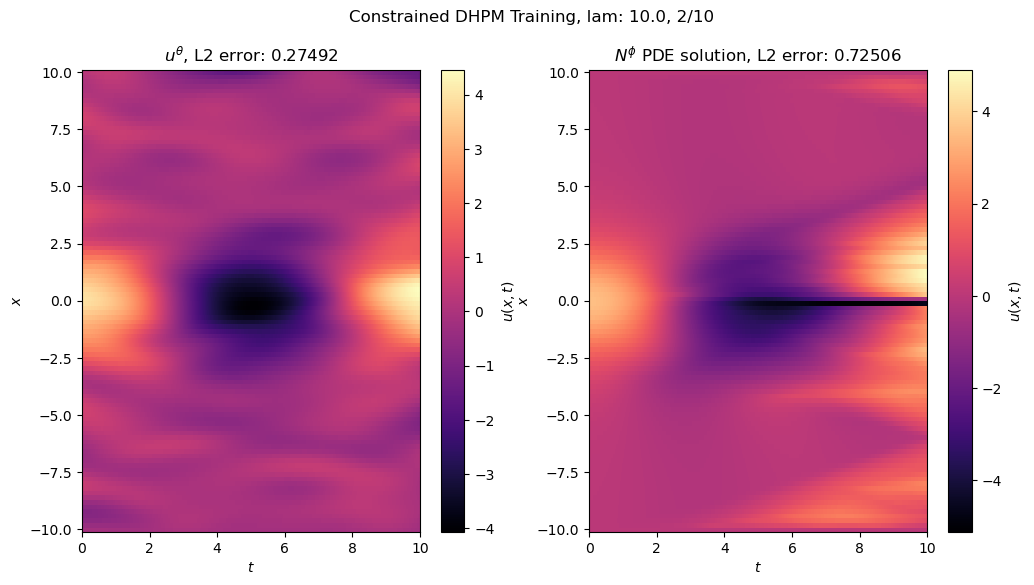

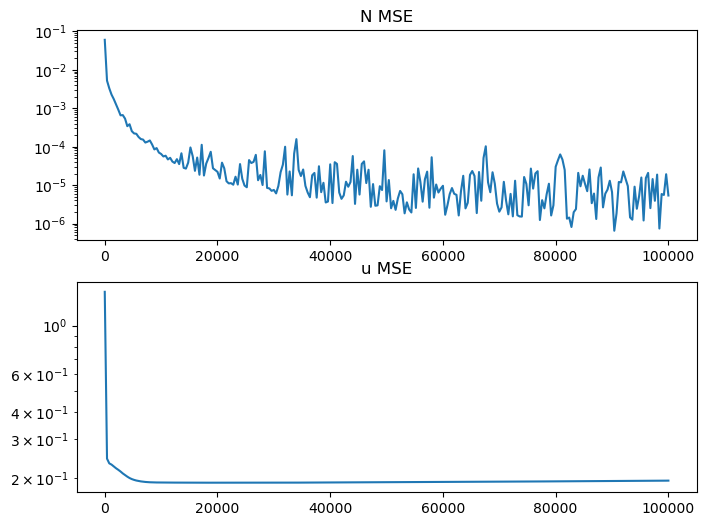

l2 nn: 0.28709, l2 pde: 1.36085
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i3_lam0.1_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.017860658467, Loss u: 0.235796093941
Epoch 800/100000, Loss N: 0.006314303726, Loss u: 0.224118724465
Epoch 1200/100000, Loss N: 0.004000689834, Loss u: 0.218107149005
Epoch 1600/100000, Loss N: 0.002573494567, Loss u: 0.215405568480
Epoch 2000/100000, Loss N: 0.001736055478, Loss u: 0.212232857943
Epoch 2400/100000, Loss N: 0.001158624887, Loss u: 0.208353519440
Epoch 2800/100000, Loss N: 0.000799236295, Loss u: 0.206447049975
Epoch 3200/100000, Loss N: 0.000673129107, Loss u: 0.205527499318
Epoch 3600/100000, Loss N: 0.000539212371, Loss u: 0.204798012972
Epoch 4000/100000, Loss N: 0.000472912652, Loss u: 0.204275712371
Epoch 4400/100000, Loss N: 0.000441714306, Loss u: 0.203898325562
Epoch 4800/100000, Loss N: 0.000384320214, Loss u: 0.203667551279
Epoch 5

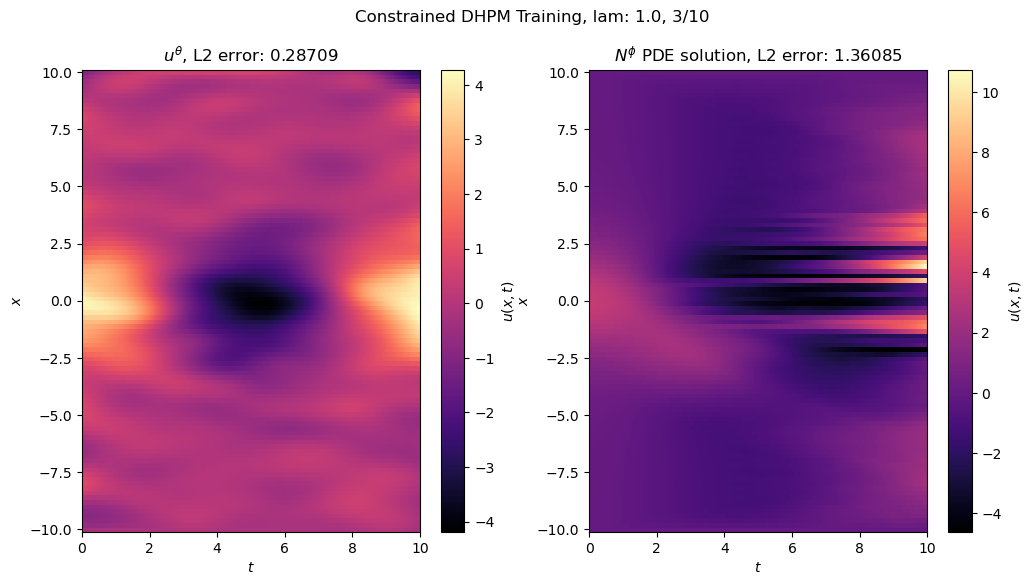

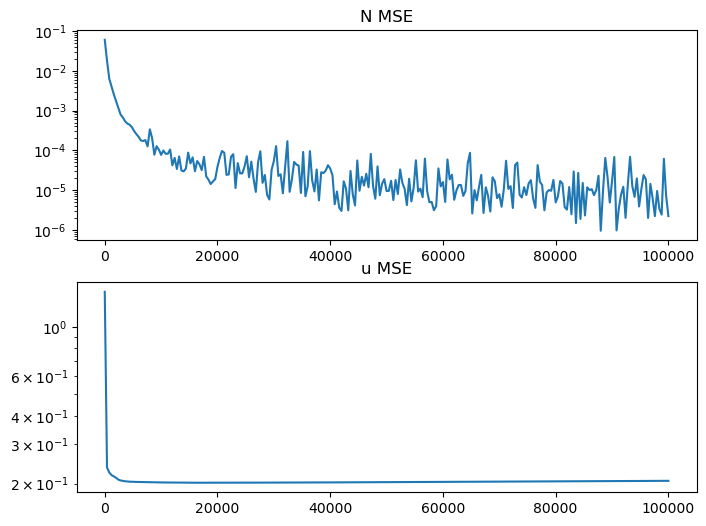

l2 nn: 0.24355, l2 pde: 2.01244
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i4_lam0.01_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.015817631036, Loss u: 0.235604703426
Epoch 800/100000, Loss N: 0.006342458073, Loss u: 0.225327432156
Epoch 1200/100000, Loss N: 0.003716087434, Loss u: 0.217690616846
Epoch 1600/100000, Loss N: 0.002320247237, Loss u: 0.212757915258
Epoch 2000/100000, Loss N: 0.001645184704, Loss u: 0.206821635365
Epoch 2400/100000, Loss N: 0.001123670954, Loss u: 0.204129040241
Epoch 2800/100000, Loss N: 0.000809292600, Loss u: 0.202286750078
Epoch 3200/100000, Loss N: 0.000567026495, Loss u: 0.201157316566
Epoch 3600/100000, Loss N: 0.000439773343, Loss u: 0.200356811285
Epoch 4000/100000, Loss N: 0.000463378034, Loss u: 0.199734792113
Epoch 4400/100000, Loss N: 0.000384127983, Loss u: 0.199101626873
Epoch 4800/100000, Loss N: 0.000259235705, Loss u: 0.198474019766
Epoch 

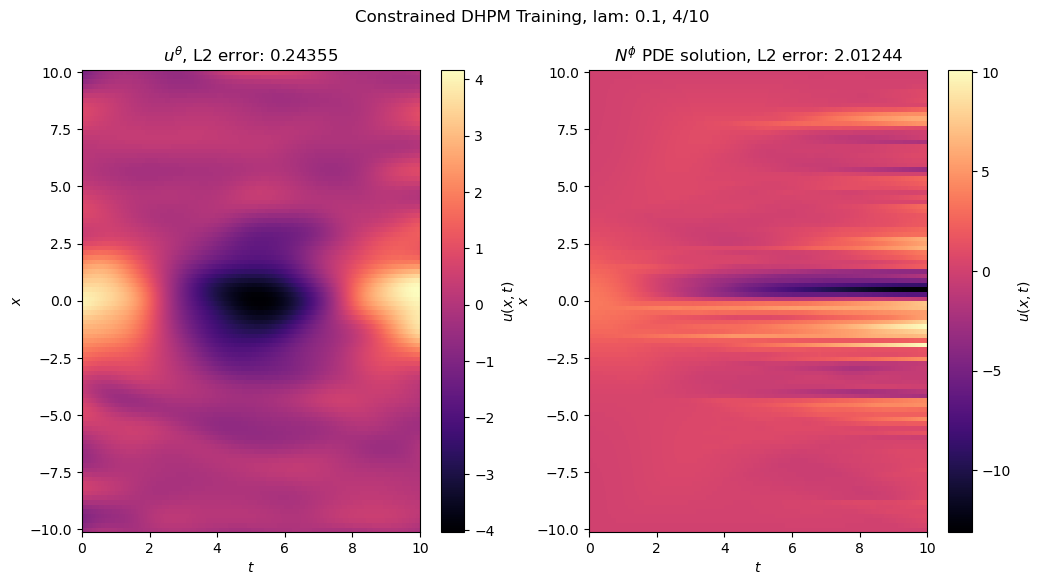

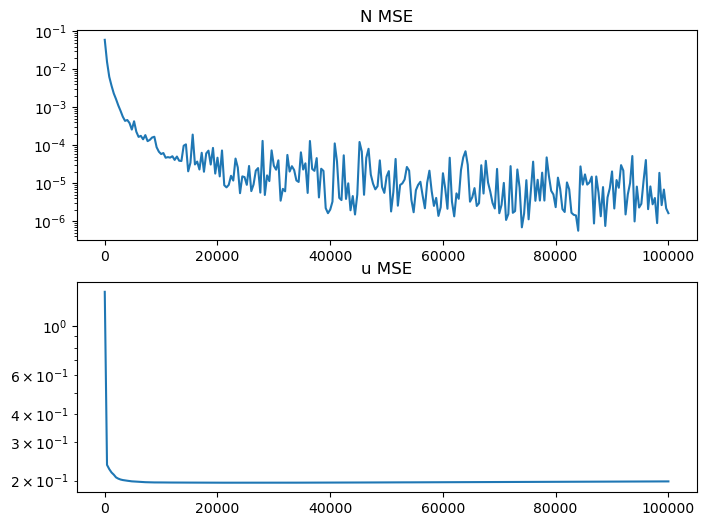

l2 nn: 0.25882, l2 pde: 2.21037
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i5_lam0.001_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.014969597571, Loss u: 0.235628888011
Epoch 800/100000, Loss N: 0.005372117274, Loss u: 0.226133972406
Epoch 1200/100000, Loss N: 0.003671437036, Loss u: 0.221674054861
Epoch 1600/100000, Loss N: 0.002280886052, Loss u: 0.217509552836
Epoch 2000/100000, Loss N: 0.001434190432, Loss u: 0.213545650244
Epoch 2400/100000, Loss N: 0.001095978776, Loss u: 0.208412453532
Epoch 2800/100000, Loss N: 0.000864777714, Loss u: 0.204174086452
Epoch 3200/100000, Loss N: 0.000627283240, Loss u: 0.201721817255
Epoch 3600/100000, Loss N: 0.000467923121, Loss u: 0.199829697609
Epoch 4000/100000, Loss N: 0.000412777212, Loss u: 0.198591560125
Epoch 4400/100000, Loss N: 0.000352192932, Loss u: 0.197778850794
Epoch 4800/100000, Loss N: 0.000348490605, Loss u: 0.197209700942
Epoch

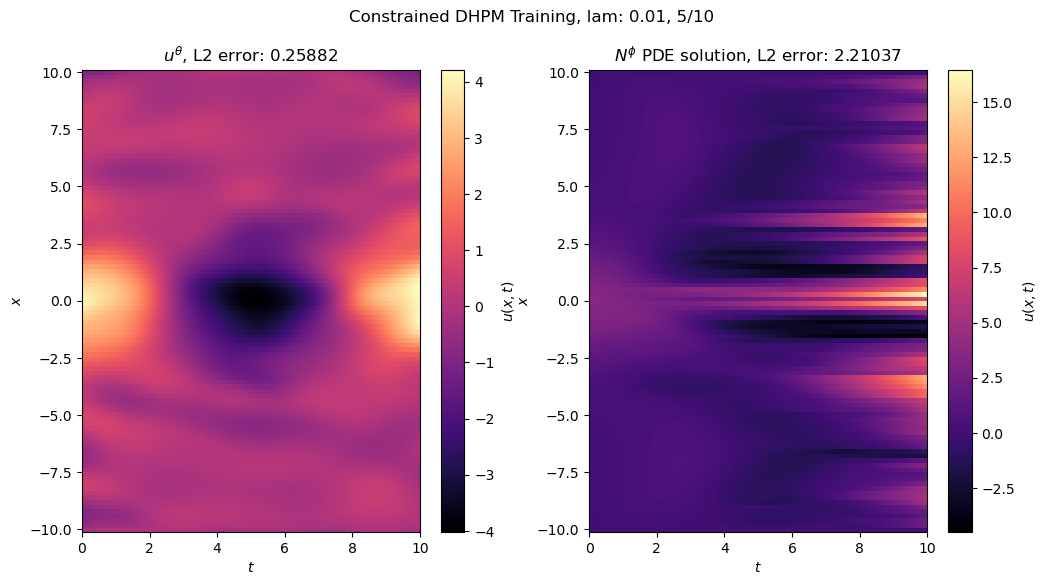

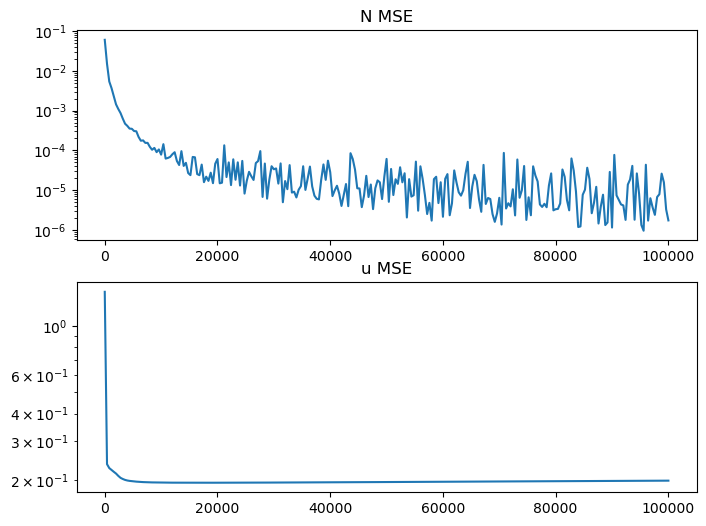

l2 nn: 0.27126, l2 pde: 2.73950
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i6_lam0.0001_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.015061237849, Loss u: 0.235620915890
Epoch 800/100000, Loss N: 0.005572594702, Loss u: 0.226125925779
Epoch 1200/100000, Loss N: 0.003686844604, Loss u: 0.223010793328
Epoch 1600/100000, Loss N: 0.002161676995, Loss u: 0.219222262502
Epoch 2000/100000, Loss N: 0.001381843002, Loss u: 0.215481042862
Epoch 2400/100000, Loss N: 0.000986049185, Loss u: 0.211760699749
Epoch 2800/100000, Loss N: 0.000798810041, Loss u: 0.209513872862
Epoch 3200/100000, Loss N: 0.000667402870, Loss u: 0.207482531667
Epoch 3600/100000, Loss N: 0.000555572275, Loss u: 0.205981403589
Epoch 4000/100000, Loss N: 0.000461177318, Loss u: 0.204328775406
Epoch 4400/100000, Loss N: 0.000372620416, Loss u: 0.203461125493
Epoch 4800/100000, Loss N: 0.000304385845, Loss u: 0.202869281173
Epoc

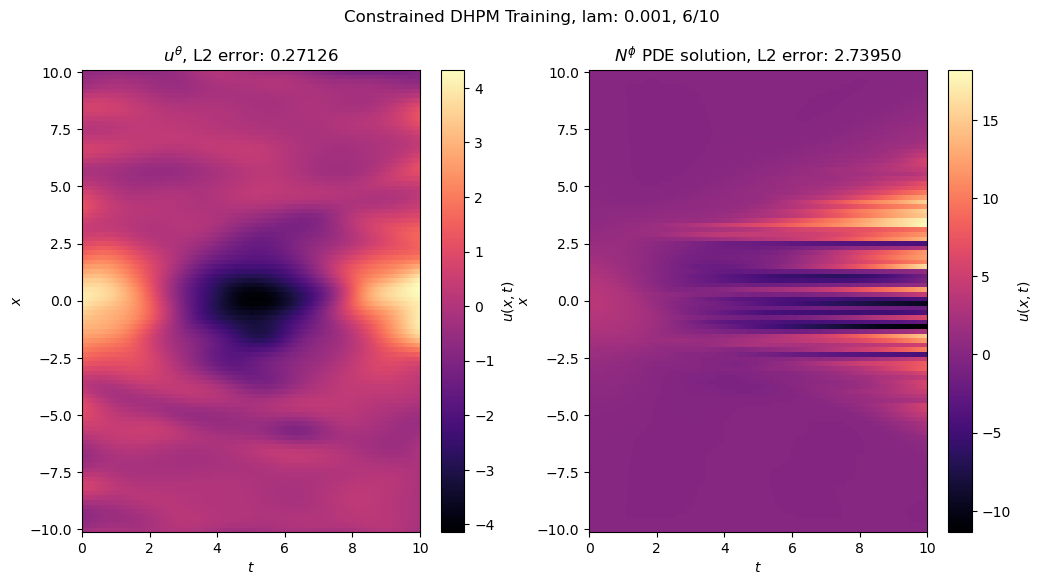

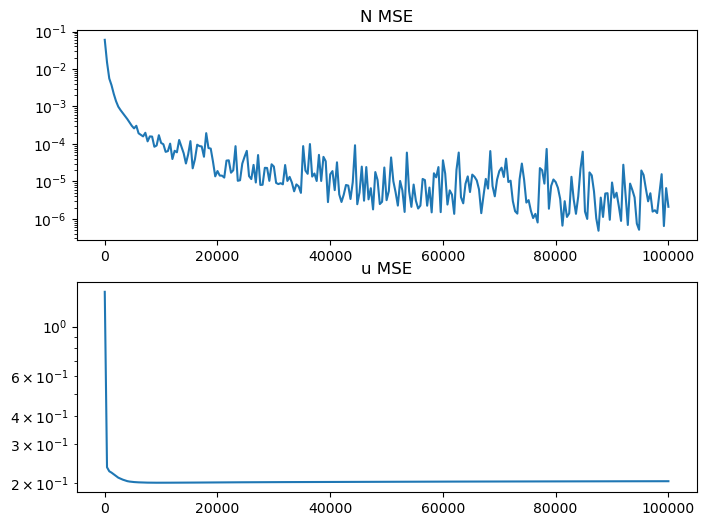

l2 nn: 0.25108, l2 pde: 3.12715
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i7_lam1e-05_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.015102682635, Loss u: 0.235629677773
Epoch 800/100000, Loss N: 0.005973439664, Loss u: 0.225796058774
Epoch 1200/100000, Loss N: 0.003780928906, Loss u: 0.220090284944
Epoch 1600/100000, Loss N: 0.002072867705, Loss u: 0.214553162456
Epoch 2000/100000, Loss N: 0.001306632534, Loss u: 0.211425095797
Epoch 2400/100000, Loss N: 0.000963328464, Loss u: 0.209292262793
Epoch 2800/100000, Loss N: 0.000767545833, Loss u: 0.206773221493
Epoch 3200/100000, Loss N: 0.000618206279, Loss u: 0.204234227538
Epoch 3600/100000, Loss N: 0.000502499344, Loss u: 0.202235057950
Epoch 4000/100000, Loss N: 0.000430605316, Loss u: 0.200726598501
Epoch 4400/100000, Loss N: 0.000416270108, Loss u: 0.199543014169
Epoch 4800/100000, Loss N: 0.000322324166, Loss u: 0.198678150773
Epoch

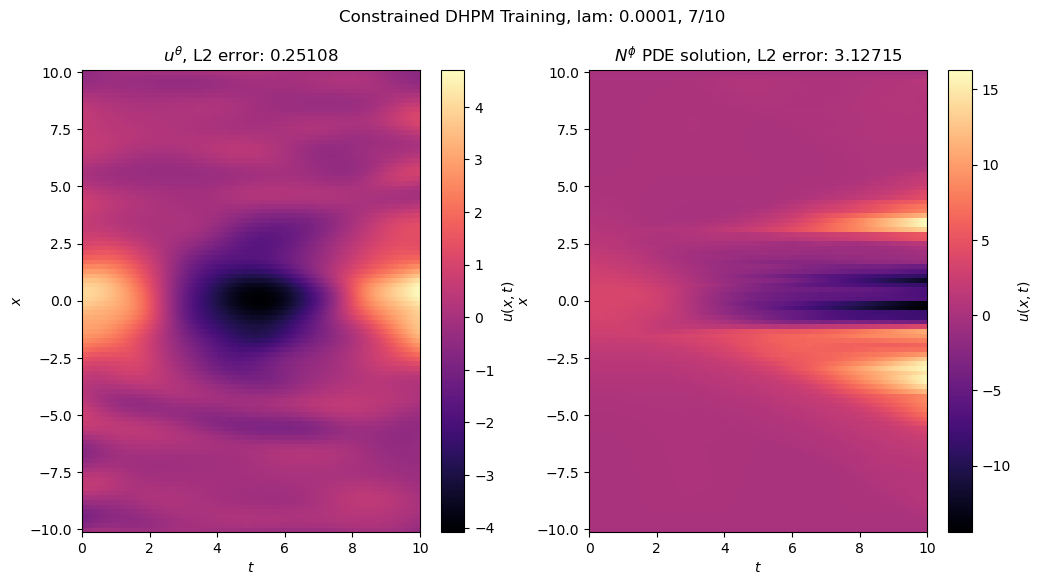

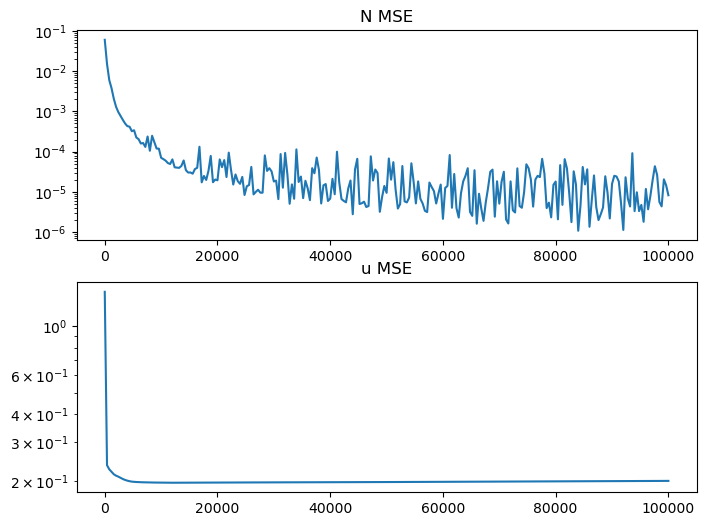

l2 nn: 0.25246, l2 pde: 1.90375
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i8_lam1e-06_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.015126038343, Loss u: 0.235618576407
Epoch 800/100000, Loss N: 0.005901617929, Loss u: 0.225851505995
Epoch 1200/100000, Loss N: 0.003949161619, Loss u: 0.220111384988
Epoch 1600/100000, Loss N: 0.002375074662, Loss u: 0.214893206954
Epoch 2000/100000, Loss N: 0.001424619462, Loss u: 0.209887325764
Epoch 2400/100000, Loss N: 0.001093159313, Loss u: 0.206155344844
Epoch 2800/100000, Loss N: 0.000847618503, Loss u: 0.203588843346
Epoch 3200/100000, Loss N: 0.000620975450, Loss u: 0.201760485768
Epoch 3600/100000, Loss N: 0.000465848541, Loss u: 0.200150370598
Epoch 4000/100000, Loss N: 0.000399604585, Loss u: 0.198868408799
Epoch 4400/100000, Loss N: 0.000452519045, Loss u: 0.197915568948
Epoch 4800/100000, Loss N: 0.000348796748, Loss u: 0.197055920959
Epoch

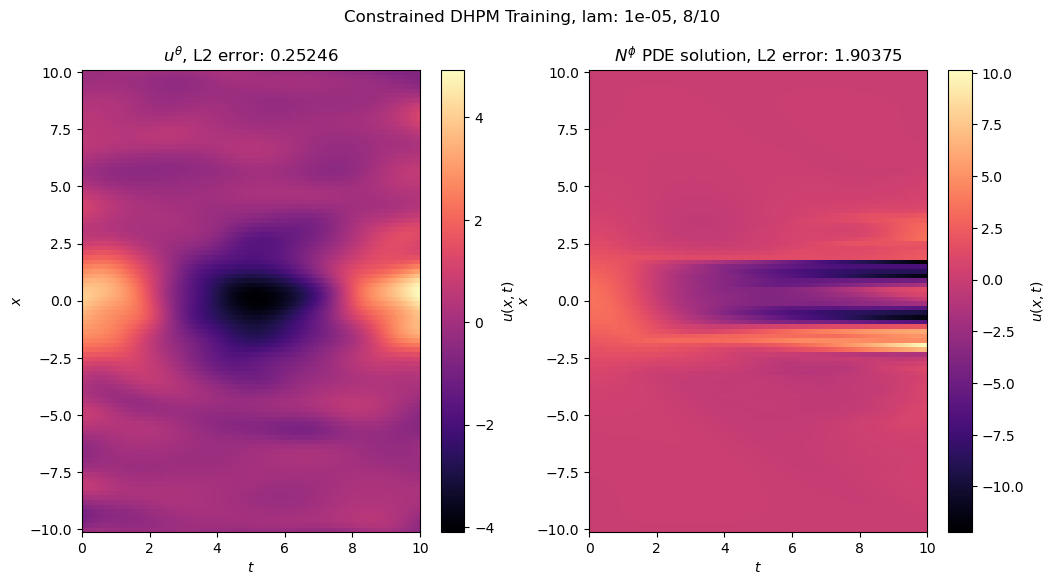

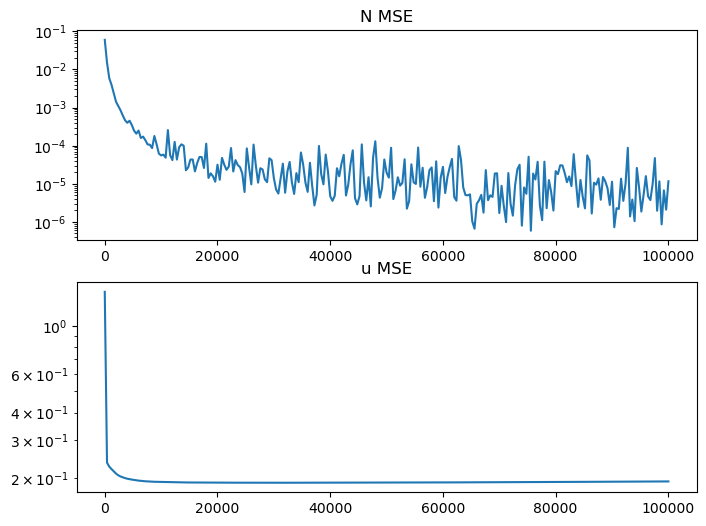

l2 nn: 0.26564, l2 pde: 2.33870
Training model ../models/ssx5_sst80_nl0.5_nx100_nt2000_breather/dhpm_lam_i9_lam1e-07_of10_e100000_lr0.001.pkl
Epoch 0/100000, Loss N: 0.059989724308, Loss u: 1.429531335831
Epoch 400/100000, Loss N: 0.015192170627, Loss u: 0.235626041889
Epoch 800/100000, Loss N: 0.006042160094, Loss u: 0.225627630949
Epoch 1200/100000, Loss N: 0.003614223795, Loss u: 0.218562364578
Epoch 1600/100000, Loss N: 0.002193867229, Loss u: 0.214786574244
Epoch 2000/100000, Loss N: 0.001404347015, Loss u: 0.211599320173
Epoch 2400/100000, Loss N: 0.000974056777, Loss u: 0.207527264953
Epoch 2800/100000, Loss N: 0.000762304058, Loss u: 0.205698102713
Epoch 3200/100000, Loss N: 0.000698899908, Loss u: 0.204954087734
Epoch 3600/100000, Loss N: 0.000554656435, Loss u: 0.204604655504
Epoch 4000/100000, Loss N: 0.000492780295, Loss u: 0.204371362925
Epoch 4400/100000, Loss N: 0.000415664661, Loss u: 0.204165562987
Epoch 4800/100000, Loss N: 0.000342726824, Loss u: 0.203877598047
Epoch

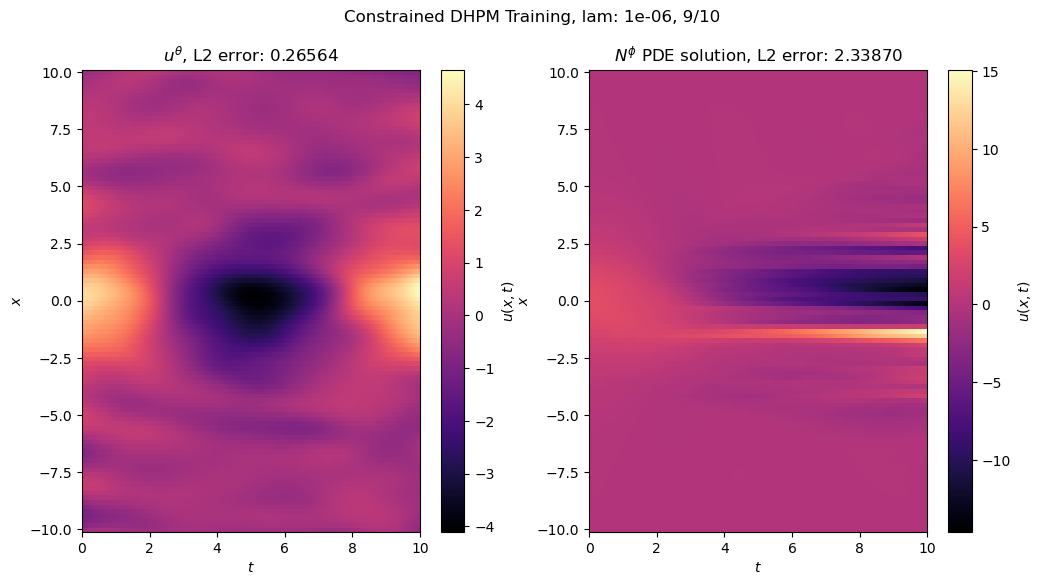

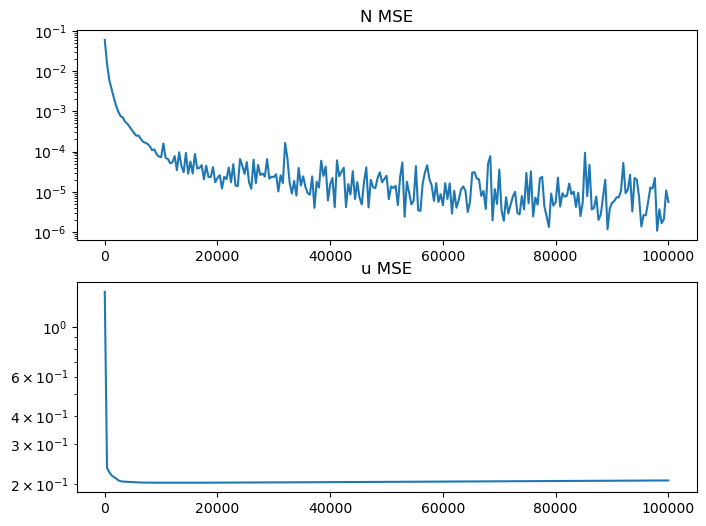

l2 nn: 0.24380, l2 pde: 2.01869


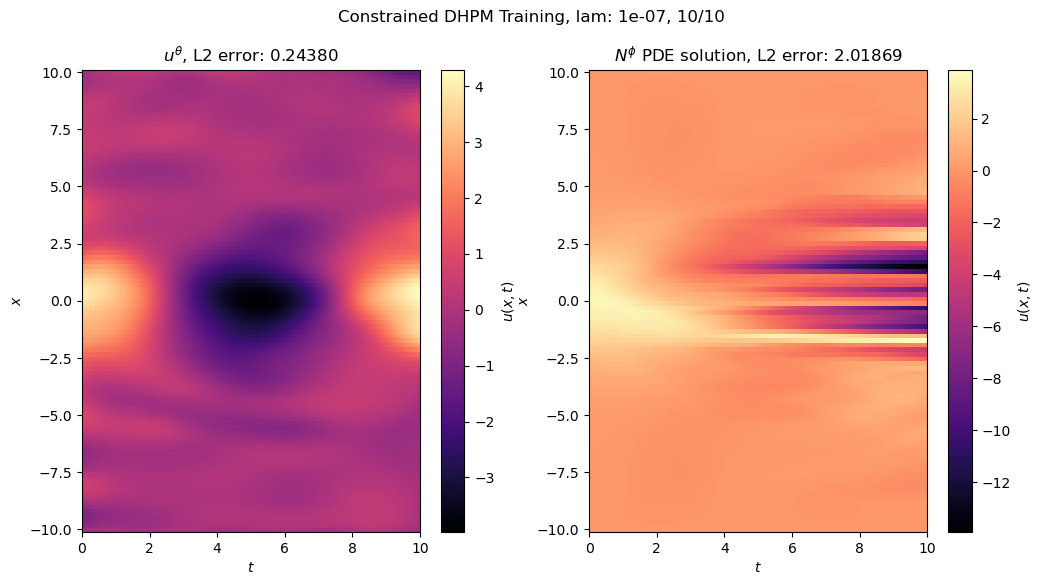

In [6]:
from copy import deepcopy
lam0s = [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# make a deep copy of the model, so we can train from scratch each time
lr = 1e-3
epochs = 100000
model_copy = deepcopy(model)

for lam_index, lam0 in enumerate(lam0s):
    lam_fname = f'{save_folder}/dhpm_lam_i{lam_index}_lam{lam0}_of{len(lam0s)}_e{epochs}_lr{lr}.pkl'
    if os.path.exists(lam_fname):
        print(f'Skipping model from {lam_fname}')
        # read the model
        with open(lam_fname, 'rb') as f:
            model = pickle.load(f)
    else:
        print(f'Training model {lam_fname}')
        training_config = {
                'epochs': epochs,
                'learning_rate': lr,
                'lam': lam0,
                # 'optimizer_type': 'LBFGS',
                'optimizer_type': 'Adam',
                # 'params': ['u', 'N'],
                'params': ['u', 'N', 'lams'],
        }
        model = deepcopy(model_copy)
        model.to(device)
        xt_train = xt_train.to(device)
        u_train = u_train.to(device)
        xt_f = xt_f.to(device)

        if 'lams' in training_config['params']:
            tracker, lams = training.train_dhpm(model, xt_train, u_train, xt_f, training_config)
        else:
            tracker = training.train_dhpm(model, xt_train, u_train, xt_f, training_config)
        tracker.plot_training_history()

        # back to cpu
        model = model.cpu()
        xt_train = xt_train.cpu()
        u_train = u_train.cpu()
        xt_f = xt_f.cpu()

        # save model
        with open(lam_fname, 'wb') as f:
            pickle.dump(model, f)
    plot_model()
    plt.suptitle(f'Constrained DHPM Training, lam: {lam0}, {lam_index+1}/{len(lam0s)}')

In [26]:
# lr = 1e-3
# epochs = 5000
# # lam = 0
# lam = 1e0

# base_fname = f'{save_folder}/dhpm_lr{lr}_e{epochs}_lam{lam}.pkl'
# if os.path.exists(base_fname):
#     print(f'Loading model from {base_fname}')
#     with open(base_fname, 'rb') as f:
#         model = pickle.load(f)
# else:
#     print(f'Did not load model')
#     training_config = {
#             'epochs': epochs,
#             'learning_rate': lr,
#             'lam': lam,
#             # 'optimizer_type': 'LBFGS',
#             'optimizer_type': 'Adam',
#             'params': ['u', 'N'],
#             # 'params': ['u', 'N', 'lams'],
#         }
#     model.to(device)
#     xt_train = xt_train.to(device)
#     u_train = u_train.to(device)
#     xt_f = xt_f.to(device)

#     if 'lams' in training_config['params']:
#         tracker, lams = training.train_dhpm(model, xt_train, u_train, xt_f, training_config)
#     else:
#         tracker = training.train_dhpm(model, xt_train, u_train, xt_f, training_config)
#     tracker.plot_training_history()

#     # back to cpu
#     model = model.cpu()
#     xt_train = xt_train.cpu()
#     u_train = u_train.cpu()
#     xt_f = xt_f.cpu()

#     # save model
#     with open(base_fname, 'wb') as f:
#         pickle.dump(model, f)

# plot_model()
# plt.suptitle(f'Initial DHPM Training')

Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i0_eps100.0_of10.pkl
l2 nn: 0.01881, l2 pde: 1.61991
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i1_eps10.0_of10.pkl
l2 nn: 0.01527, l2 pde: 0.63989
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i2_eps1.0_of10.pkl
l2 nn: 0.01541, l2 pde: 0.65664
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i3_eps0.1_of10.pkl
l2 nn: 0.01004, l2 pde: 0.13848
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i4_eps0.01_of10.pkl
l2 nn: 0.01114, l2 pde: 0.12095
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i5_eps0.001_of10.pkl
l2 nn: 0.01413, l2 pde: 0.10879
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i6_eps0.0001_of10.pkl
l2 nn: 0.01603, l2 pde: 0.09354
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i7_eps1e-05_of10.p

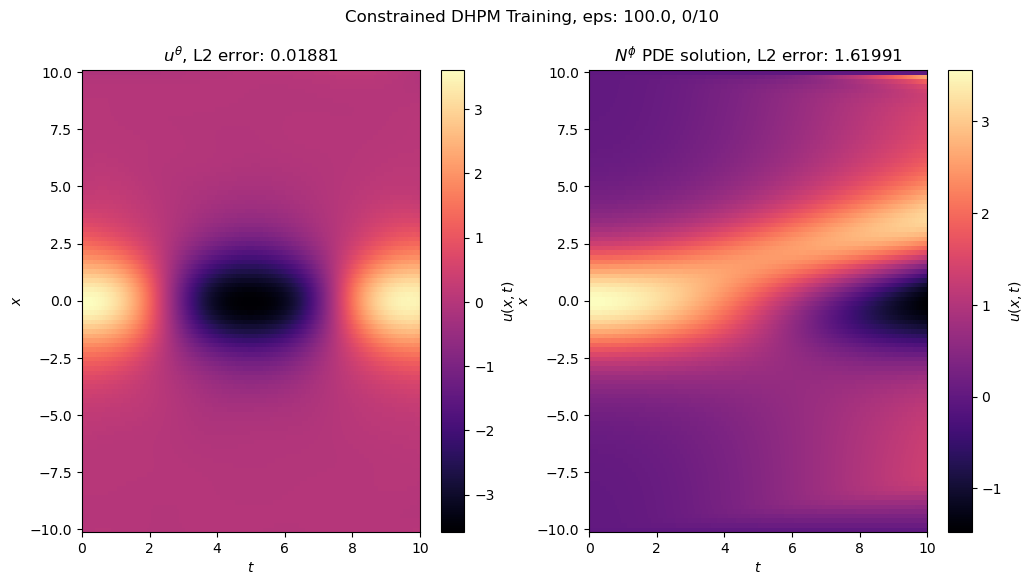

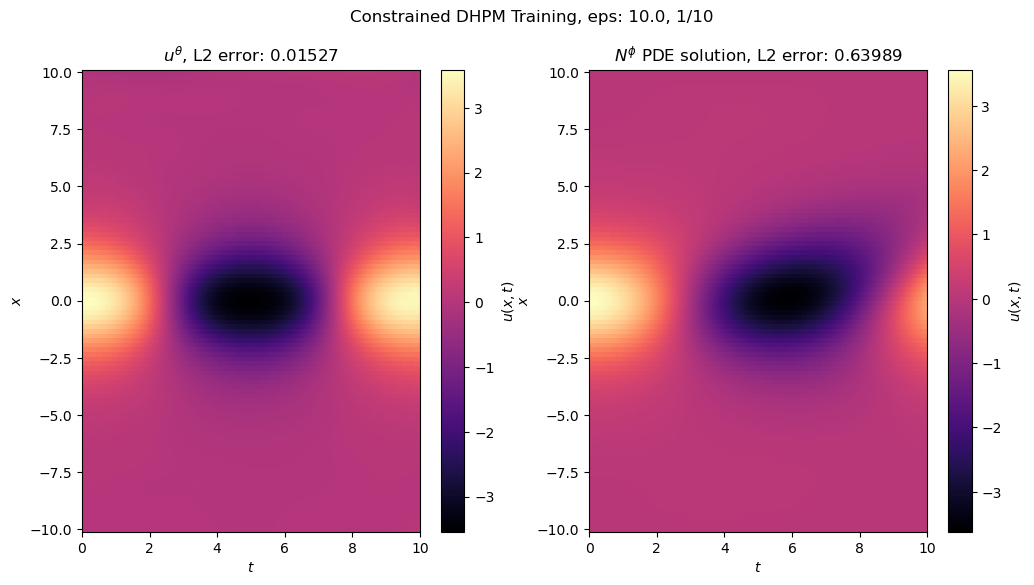

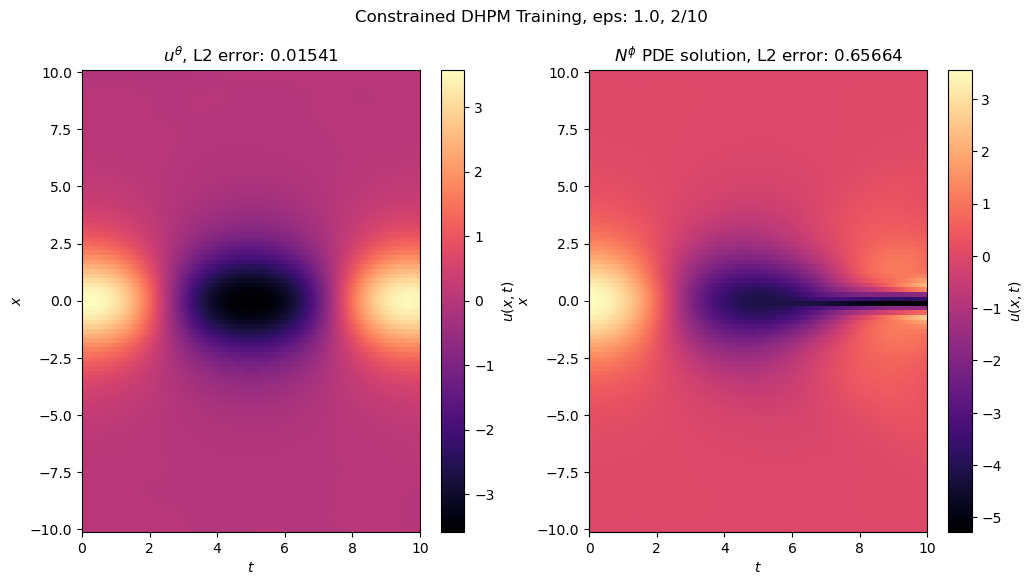

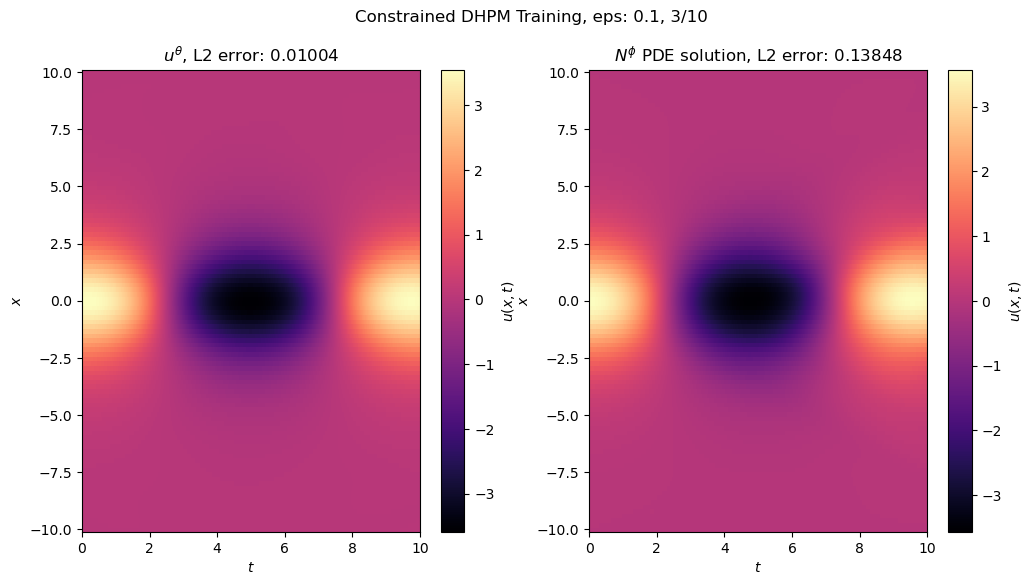

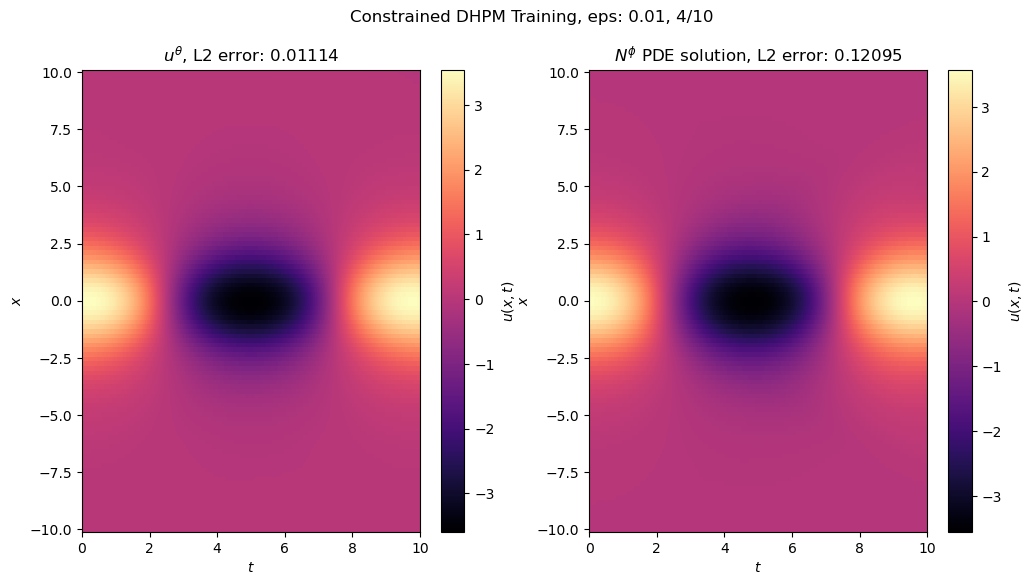

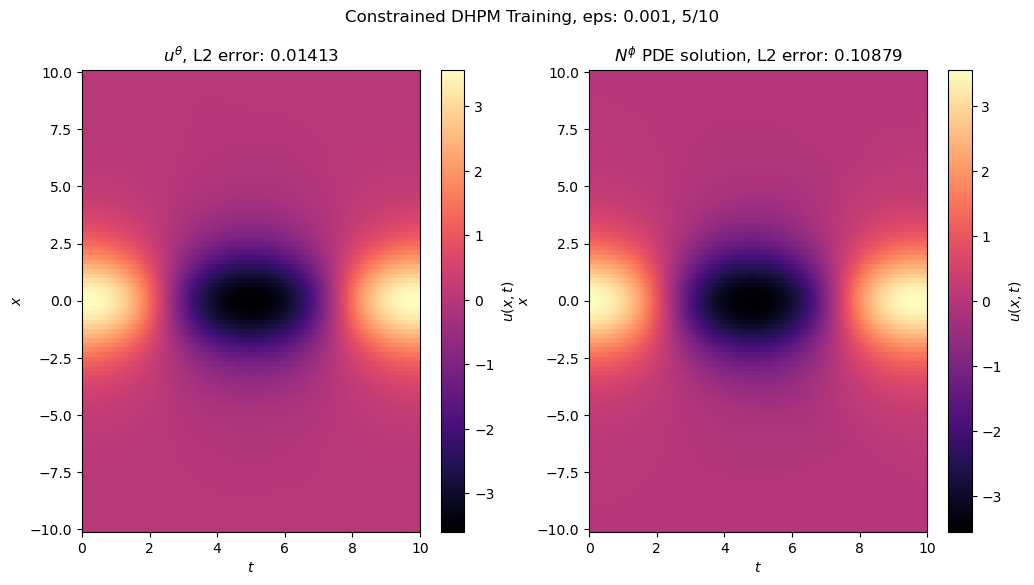

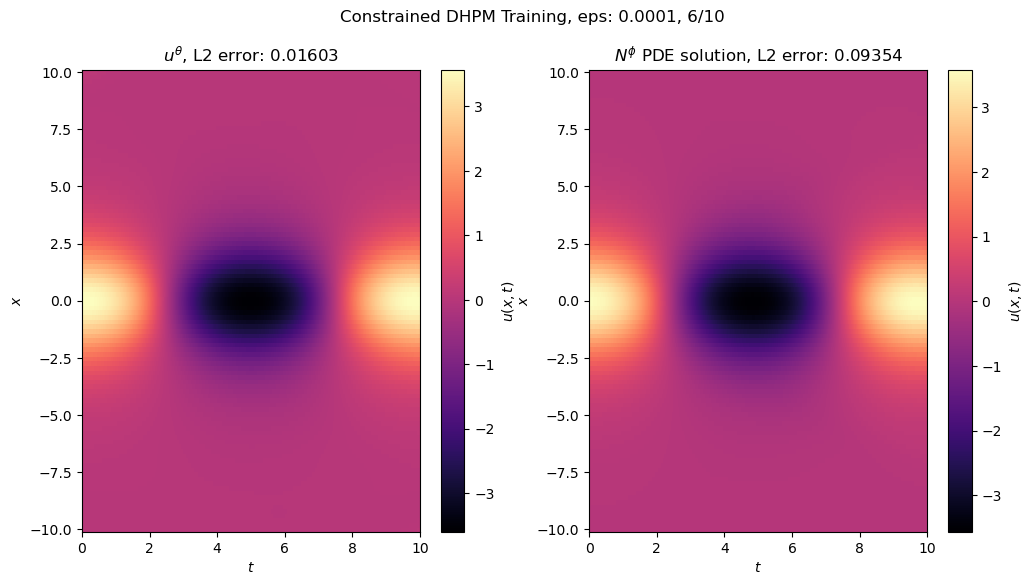

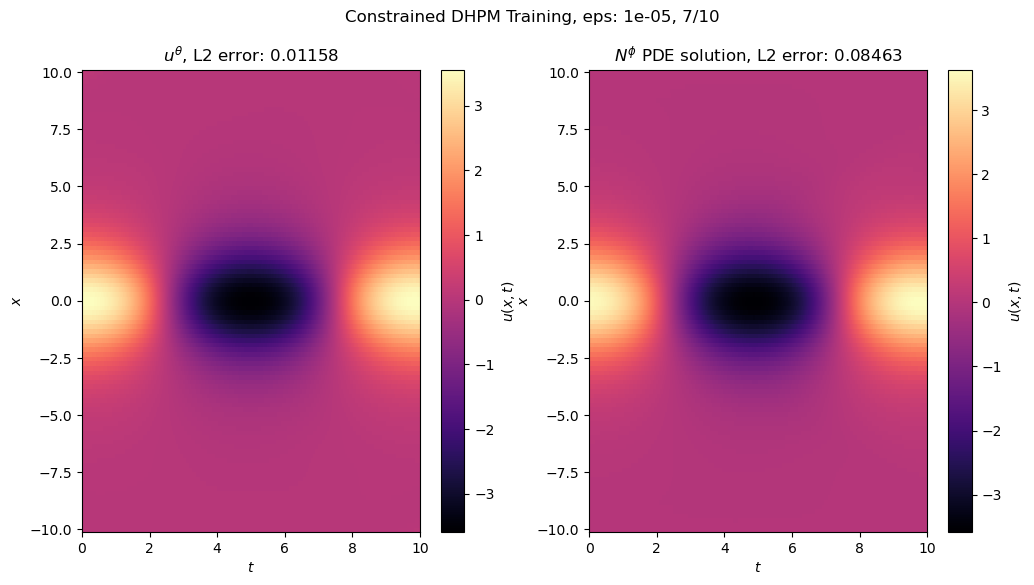

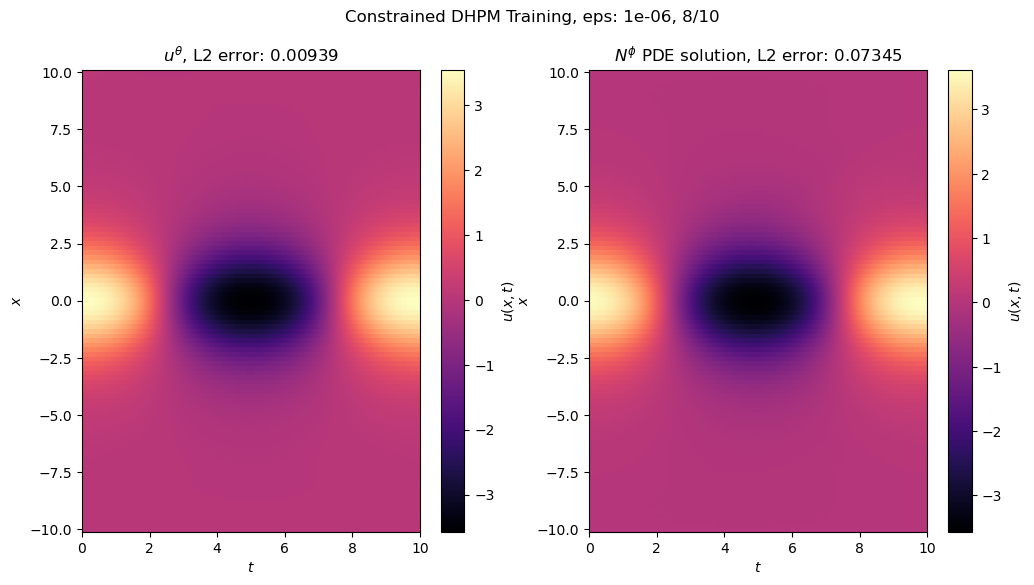

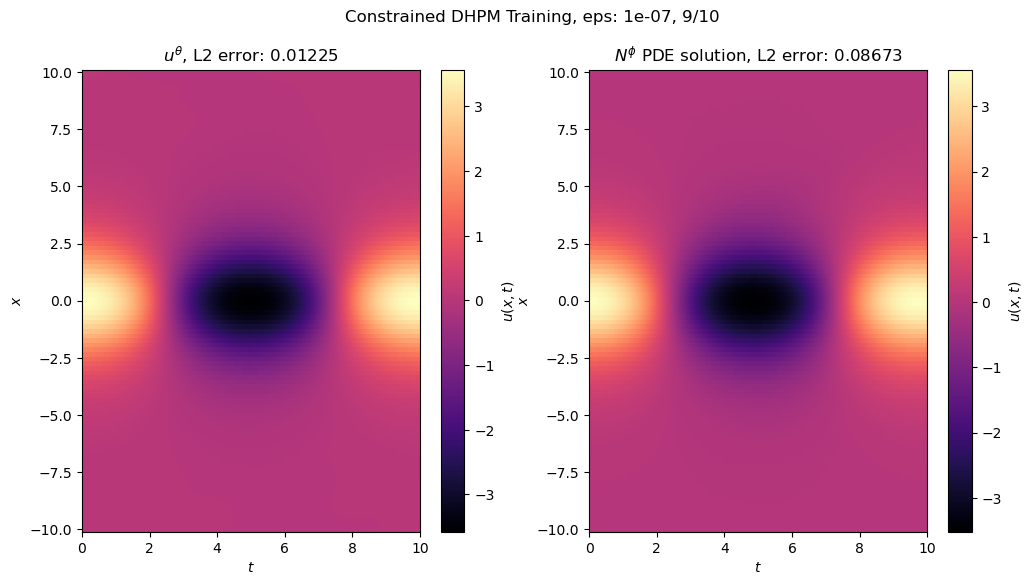

In [27]:
epses = [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# epses = [1e-2]
for eps_index, eps in enumerate(epses):
    eps_fname = f'{save_folder}/dhpm_eps_i{eps_index}_eps{eps}_of{len(epses)}.pkl'
    if os.path.exists(eps_fname):
        print(f'Loading model from {eps_fname}')
        with open(eps_fname, 'rb') as f:
            model = pickle.load(f)
    else:
        training_config = {
                'epochs': 1000,
                'eps': eps,
                'verbosity': 1
            }
        tracker, res = training.train_dhpm_constrained(model, xt_train, u_train, xt_f, training_config)
        with open(eps_fname, 'wb') as f:
            pickle.dump(model, f)
    plot_model()
    plt.suptitle(f'Constrained DHPM Training, eps: {eps}, {eps_index+1}/{len(epses)}')